# Viz data

Souces:

- https://colab.research.google.com/github/hardik0/AI-for-Medicine-Specialization/blob/master/AI-for-Medical-Diagnosis/Week-3/Explore_MRI_data.ipynb#scrollTo=nLgMNEFolcHr

In [1]:
# set root directory of data
DATA = f"/home/gologors/data/test/1.2.840.113711.98223.701.3360.497997740.26.2116281012.1240820"

In [2]:
# utilities
import os, sys, time, json

# graphing
from matplotlib import gridspec, colors

import matplotlib.pyplot as plt
import seaborn as sns

# data
import numpy as np
import pandas as pd

# nii
import SimpleITK as sitk

# interactive
from ipywidgets import interact, interactive, IntSlider, ToggleButtons, fixed

# helpers

# add root to filepath (=os.path.join)
def getfp(fn, root=DATA): return f"{root}/{fn}"

# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

# round all floats in a tuple to 3 decimal places
def round_tuple(t, d=2): return tuple(round(x,d) for x in t)

def orient_test(image):
    orient = sitk.DICOMOrientImageFilter()
    orient.DebugOn()
    print(round_tuple(image.GetDirection(), d=2))
    print(orient.GetOrientationFromDirectionCosines(image.GetDirection()))

# print sitk info
def print_sitk_info(image):   
    orient = sitk.DICOMOrientImageFilter()

    print("Size: ", image.GetSize())
    print("Origin: ", image.GetOrigin())
    print("Spacing: ", image.GetSpacing())
    print("Direction: ", round_tuple(image.GetDirection(), d=2))
    print("Orientation: ", orient.GetOrientationFromDirectionCosines(image.GetDirection()))
    print(f"Pixel type: {image.GetPixelIDValue()} = {image.GetPixelIDTypeAsString()}")

In [3]:
# read sequence names from csv
series_info = pd.read_csv(getfp("Series_2.csv"), header=None)
display(series_info.head())
print(series_info.loc[:,5])

,0,1,2,3,4,5,6,7,8,9
0,103,1.3.46.670589.11.37169.5.0.1344.20161020035431...,MR,20161020,35320.53,Patient Aligned MPR AWPLAN_SMARTPLAN_TYPE_BRAIN,HFS,HEAD,Philips Medical Systems,1.3.46.670589.11.37169.5.0.7084.20161020035222...
1,301,1.3.46.670589.11.37169.5.0.7164.20161020035616...,MR,20161020,35616.79,SAG T1,HFS,HEAD,Philips Medical Systems,1.3.46.670589.11.37169.5.0.7084.20161020035222...
2,401,1.3.46.670589.11.37169.5.0.7164.20161020035844...,MR,20161020,35844.59,AX DWI,HFS,HEAD,Philips Medical Systems,1.3.46.670589.11.37169.5.0.7084.20161020035222...
3,402,1.3.46.670589.11.37169.5.0.5308.20161020040123...,MR,20161020,35844.59,dADC_DWI SENSE,HFS,HEAD,Philips Medical Systems,1.3.46.670589.11.37169.5.0.7084.20161020035222...
4,403,1.3.46.670589.11.37169.5.0.5308.20161020040123...,MR,20161020,35844.59,eADC_DWI SENSE,HFS,HEAD,Philips Medical Systems,1.3.46.670589.11.37169.5.0.7084.20161020035222...


0     Patient Aligned MPR AWPLAN_SMARTPLAN_TYPE_BRAIN
1                                              SAG T1
2                                              AX DWI
3                                      dADC_DWI SENSE
4                                      eADC_DWI SENSE
5                                         AX T2 FLAIR
6                                              AX T2*
7                                              COR T1
8                                              COR T2
9                                         +DYN T1 PIT
10                                            +SAG T1
11                                            +COR T1
12                                             +AX T1
Name: 5, dtype: object


# Sequences to align

We align the following: Cor T1, Cor T2, +Cor T1 (i.e. with contrast).

1. Get .niis associated w/ seq
2. Convert .nii to sitk obj
    - re-orient to LAS
    - crop to foreground via threshold
3. Resample all sitk objs to same reference frame
4. Elastix rigid align (Euler transform) via reg.py

In [4]:
def seq2fp(seq):
    """ Get .nii filename associated w/ seq """
    
    # get filepath to sequence
    seq_idx = series_info.loc[:,5] == seq
    fn      = series_info.loc[seq_idx,1].values[0]
    
    # get files in dir
    all_files = sorted(os.listdir(getfp(fn)))
    niis  = [x for x in all_files if x.endswith(".nii.gz")]
    jsons = [x for x in all_files if x.endswith(".json")] 
    dcms  = [x for x in all_files if x.endswith(".dcm")]
    
    # check if more than one
    if len(niis) != 1:
        print(f"Nii isn't unique! {seq}")
        
    return getfp(f"{fn}/{niis[0]}")

def fp2sitk(fp):
    """ Orient to LAS & Crop to Foreground """
    im_obj = sitk.ReadImage(fp)
    return threshold_based_crop(sitk.DICOMOrient(im_obj, "LAS"))
    
# Crop https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def threshold_based_crop(image):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])

# get standard reference domain

# src: https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def get_reference_frame(objs, new_spacing):
    img_data = [(o.GetSize(), o.GetSpacing()) for o in objs]

    dimension = 3 # 3D MRs
    pixel_id = 8 # 2 = 16-bit signed integer

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    for img_sz, img_spc in img_data:
        reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                      for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]

    # Create the reference image with a zero origin, identity direction cosine matrix and dimension     
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()

    # Non-Isotropic pixels
    reference_spacing = new_spacing
    reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

    # Set reference image attributes
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    return reference_image, (reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center)

def get_reference_image(reference_frame):
    reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    return reference_image, reference_center

def resample2reference(img, reference_image, reference_center, \
                       interpolator = sitk.sitkLinear, default_intensity_value = 0.0, dimension=3):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_image.GetOrigin())
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    
    centered_transform = sitk.CompositeTransform([transform, centering_transform])
    
#     centered_transform = sitk.Transform(transform)
#     centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value, img.GetPixelID())

In [5]:
seqs = ["COR T1", "COR T2", "+COR T1"]
fps  = {seq:seq2fp(seq) for seq in seqs}
objs = {seq:fp2sitk(fp) for seq,fp in fps.items()}

In [6]:
for seq,obj in objs.items():
    print("*"*50)
    print(seq)
    print_sitk_info(obj)
    print("*"*50)

**************************************************
COR T1
Size:  (380, 17, 484)
Origin:  (-98.93094815072925, 15.964123981760224, -110.72881635369274)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
COR T2
Size:  (356, 17, 454)
Origin:  (-98.94240546854581, 15.963736497488119, -110.7132399431765)
Spacing:  (0.4375, 3.0, 0.4375)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
+COR T1
Size:  (383, 17, 489)
Origin:  (-99.33489810000317, 15.92953018699912, -110.66672080425725)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 =

# Fig 0: Before resampling to same reference frame

In [7]:
ims = {seq:sitk2np(o) for seq,o in objs.items()}

axis = 1
nslices = ims["COR T1"].shape[axis]

print(nslices)

17


NameError: name 'to_binary_im' is not defined

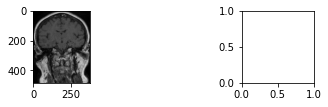

In [8]:
ncols = len(ims) + len(ims) + 1
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, (seq, im_arr) in enumerate(ims.items()):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # plot binary cmaps
        ax_next = plt.subplot(gs[row_idx,col_idx+len(ims)])
        ax_next.imshow(np.rot90(to_binary_im(im)), cmap=get_binary_cm(col2=seq_colors[seq]))
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{seq}')    
            ax.xaxis.set_label_position('top') 
            
            ax_next.set_xlabel(f'{seqs[col_idx]}')    
            ax_next.xaxis.set_label_position('top') 
        
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])
        
# plot last col w/ all binary maps overlaid

for seq, im_arr in ims.items():
    print(seq, im_arr.shape)
    for row_idx, slice_idx in enumerate(range(nslices)):
           
        im_slice = np.take(to_binary_im(im_arr), slice_idx, axis=axis)

        # plot last col
        ax = plt.subplot(gs[row_idx,len(ims)+len(ims)])
        ax.imshow(np.rot90(im_slice), cmap=get_binary_cm(col2=seq_colors[seq]), alpha=0.3)
    
        if row_idx == 0:
            ax.set_xlabel(f'Binary, all')    
            ax.xaxis.set_label_position('top') 

        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle('Fig 0: Before Resampling', y=1.01, fontsize=16)
plt.axis('off')

In [ ]:
# resample to same domain
new_spacing = (0.41015625, 3.0, 0.41015625)
reference_image, reference_frame = get_reference_frame(objs.values(), new_spacing)

# unpack reference frame
reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame

# print
print("Reference Image")
print_sitk_info(reference_image)

In [ ]:
# resample to reference
resampled_objs = {seq:resample2reference(o, reference_image, reference_center) for seq,o in objs.items()}

In [ ]:
for seq,obj in resampled_objs.items():
    print("*"*50)
    print(seq)
    print_sitk_info(obj)
    print("*"*50)

In [ ]:
ims = {seq:sitk2np(o) for seq,o in resampled_objs.items()}

In [ ]:
axis = 1
nslices = ims["COR T1"].shape[axis]

print(nslices)

# Pre-Alignment

In [ ]:
def to_binary_im(img, threshold=150):
    # make all pixels < threshold black
    binarized = 1.0 * (img > threshold)
    
    return binarized

def get_binary_cm(col1="white", col2="red"): return colors.ListedColormap([col1, col2])

seq_colors = {
    "COR T1": "red", 
    "COR T2": "green", 
    "+COR T1": "blue",
    
    "Aligned COR T2": "green", 
    "Aligned +COR T1": "blue"
}

# Figure 1: Before Alignment

In [ ]:
ncols = len(ims) + len(ims) + 1
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, (seq, im_arr) in enumerate(ims.items()):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # plot binary cmaps
        ax_next = plt.subplot(gs[row_idx,col_idx+len(ims)])
        ax_next.imshow(np.rot90(to_binary_im(im)), cmap=get_binary_cm(col2=seq_colors[seq]))
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{seq}')    
            ax.xaxis.set_label_position('top') 
            
            ax_next.set_xlabel(f'{seqs[col_idx]}')    
            ax_next.xaxis.set_label_position('top') 
        
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])
        
# plot last col w/ all binary maps overlaid

for seq, im_arr in ims.items():
    print(seq, im_arr.shape)
    for row_idx, slice_idx in enumerate(range(nslices)):
           
        im_slice = np.take(to_binary_im(im_arr), slice_idx, axis=axis)

        # plot last col
        ax = plt.subplot(gs[row_idx,len(ims)+len(ims)])
        ax.imshow(np.rot90(im_slice), cmap=get_binary_cm(col2=seq_colors[seq]), alpha=0.3)
    
        if row_idx == 0:
            ax.set_xlabel(f'Binary, all')    
            ax.xaxis.set_label_position('top') 

        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle('Fig 1: Before Alignment, After Resampling', y=1.01, fontsize=16)
plt.axis('off')

# Post-Alignment

In [ ]:
def get_aligned_arr(moving_seq, fixed_seq="COR T1"):
    fn = getfp(f"elastix/resampled_{moving_seq}_aligned_to_{fixed_seq}.nii")    
    return sitk2np(sitk.ReadImage(fn))

In [ ]:
fixed_seq = "COR T1"
moving_seqs= ["COR T2", "+COR T1"]

aligned_ims = {f"Aligned {moving_seq}": get_aligned_arr(moving_seq) for moving_seq in moving_seqs}

In [ ]:
for seq,im_arr in aligned_ims.items():
    print(seq, im_arr.shape)

In [ ]:
display_ims_dict = {fixed_seq: ims[fixed_seq], **aligned_ims}

In [ ]:
print(display_ims_dict.keys())

In [ ]:
ncols = len(ims) + len(ims) + 1
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, (seq, im_arr) in enumerate(display_ims_dict.items()):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # plot binary cmaps
        ax_next = plt.subplot(gs[row_idx,col_idx+len(ims)])
        ax_next.imshow(np.rot90(to_binary_im(im)), cmap=get_binary_cm(col2=seq_colors[seq]))
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{seq}')    
            ax.xaxis.set_label_position('top') 
            
            ax_next.set_xlabel(f'{seqs[col_idx]}')    
            ax_next.xaxis.set_label_position('top') 
        
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])
        
# plot last col w/ all binary maps overlaid

for seq, im_arr in ims.items():
    print(seq, im_arr.shape)
    for row_idx, slice_idx in enumerate(range(nslices)):
           
        im_slice = np.take(to_binary_im(im_arr), slice_idx, axis=axis)

        # plot last col
        ax = plt.subplot(gs[row_idx,len(ims)+len(ims)])
        ax.imshow(np.rot90(im_slice), cmap=get_binary_cm(col2=seq_colors[seq]), alpha=0.3)
    
        if row_idx == 0:
            ax.set_xlabel(f'Binary, all')    
            ax.xaxis.set_label_position('top') 

        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle('Fig 2: After Alignment', y=1.01, fontsize=16)
plt.axis('off')

In [ ]:
moving_seqs

# Compare before-and-after

In [ ]:
# Compare before-and-after

col_names = ["COR T1", "COR T2", "Aligned COR T2", "+COR T1", "Aligned +COR T1"]

display_ims_dict = {**ims, **aligned_ims}
col_ims = [display_ims_dict[seq] for seq in col_names]

In [ ]:
ncols = len(col_ims)
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, im_arr in enumerate(col_ims):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{col_names[col_idx]}')    
            ax.xaxis.set_label_position('top') 
       
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])

fig.suptitle('Fig 3: Before & After Alignment', y=1.01, fontsize=16)
plt.axis('off')

In [ ]:
# im_arr = ims[0]
# interact(explore_3dimage, 
#          layer0=(0, im_arr.shape[0] - 1), 
#          layer1=(0, im_arr.shape[1] - 1), 
#          layer2=(0, im_arr.shape[2] - 1),
#          im_arr=fixed(im_arr));